In this simple exercise we will demostrate how to use the gradient descent as a optimization method to fit a function. We will choose a simple function thinking that it models a situation of the real world.

First of all, we will plot the function of the form _a*x^2 + b*x + c_, where a, b, and c, then we will add it some noise in order to think about it a as real problem of some dataset. Then, we will try to figure out the parameters that best fit the function with noise. At the beginning we will try it manually, but then using derivatives (gradient operation) to know how much we will modify the values to achive a better result in an iterative way.

## Function to fit

In [1]:
from ipywidgets import interact
from fastai.basics import *

In [2]:
plt.rc("figure", dpi=90)

In [3]:
def plot_function(f, title=None, min=-2.1, max=2.1, color="g", ylim=None):
    x = torch.linspace(min, max, 100)[:, None]

    if ylim:
        plt.ylim(ylim)
    
    plt.plot(x, f(x), color)
    if title:
        plt.title(label=title)

In [4]:
def f(x):
    return 3*x**2 + 4*x + 1

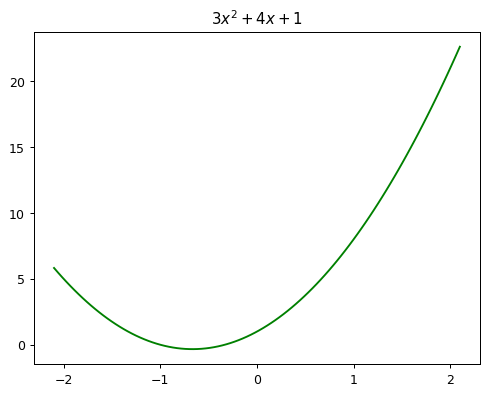

In [5]:
plot_function(f, title="$3x^2 + 4x + 1$")

The function has the a=3, b=4 and c=1 parameters. We can create a kind of template for quadratic functions to simulate the approximation of that parameters that fit the original function.

In [6]:
def quadratic(a, b, c, x):
    return a*x**2 + b*x + c

In [7]:
def mk_quad(a, b, c):
    return partial(quadratic, a, b, c)

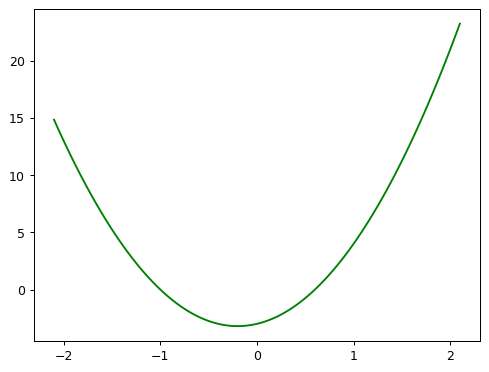

In [8]:
quad_example_fn = mk_quad(5, 2, -3)
plot_function(quad_example_fn)

We can simulate making some noisy measurements of our quadratic f.

In [9]:
def noise(x, scale):
    """Generate Gaussian variations for each point of x."""
    return np.random.normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
    """Add noise to each data point of x - by a multiplier factor and an addition."""
    return x * (1 + noise(x, mult)) + noise(x, add)

In [10]:
# to make sure reproductibility
np.random.seed(42)

# generate 20 equidistant datapoints between -2 and 2
x = torch.linspace(-2, 2, steps=20)[:, None]
# evaluate f(x) and Gaussian noise (by factor and addition)
y = add_noise(f(x), 0.15, 1.5) # ground truth

In [11]:
x[:5], y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[ 7.5710],
         [ 3.0386],
         [ 2.4749],
         [-0.7317],
         [-0.4397]], dtype=torch.float64))

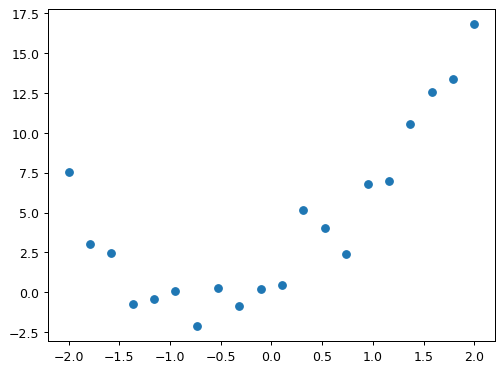

In [12]:
plt.scatter(x=x, y=y)

## Approximate the function manually

How do we find values of a, b, and c which fit this data? One approach is to try a few values and see what fits

In [13]:
@interact(a=1.1, b=1.1, c=1.1)
def plot(a, b, c):
    plt.scatter(x, y) # function that we wanna approximate
    # the function generated by the parameters that we are trying to fit
    plot_function(mk_quad(a, b, c), ylim=(-3, 13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

We can measure the fit in a numeric way to guest better values for the parameters. 
We can use the **Mean Absolute Error (MAE)** which is the distance from each data point to the original curve.

In [14]:
def mae(preds, ground_truth):
    return (torch.abs(preds - ground_truth)).mean()

This time just use the value of the metric to decide which direction to move each slider, and how far to move it.

In [15]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    # original function
    plt.scatter(x, y)
    # new function generated
    f = mk_quad(a, b, c)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In a modern neural network we'll often have tens of millions of parameters to fit, or more, and thousands or millions of data points to fit them to. We're not going to be able to do that by moving sliders around! We'll need to automate this process. **We can use derivatives to automate the process**.

## Automating gradient descent

The basic idea is...if we know the gradient of our mae() function with respect to our parameters a, b and c, then that means we know how adjusting (for instance) `a` will change the value of mae(). 

If `a` has a negative gradient, then we know that increasing `a` will decrease mae() (adjust our parameters a _bit_ in the opposite direction of the sign of the gradient).

In [16]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [17]:
# this call will calculate the mae when has the params a=1.1, b=1.1 and c=1.1

quad_mae([1.1, 1.1, 1.1])

tensor(2.9186, dtype=torch.float64)

In [18]:
params_abc = torch.tensor([1.1, 1.1, 1.1])

To indicate to PyTorch that we wanna compute the gradients for these parameters we call the next function:

In [19]:
params_abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

We evaluate mae() over those params. The result we call it "loss"

In [20]:
loss = quad_mae(params_abc)
loss

tensor(2.9186, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [21]:
# to actually compute the gradients we call backward() fn
loss.backward()

gradients_ = params_abc.grad
gradients_

tensor([-0.9141, -0.4316, -0.1000])

According to this gradient vector, we need to increase a bit the params, so let's increase them a bit and compare with the last loss which was 2.9186.

In [22]:
learning_rate = 0.01 # this is called an hyper-parameter

with torch.no_grad(): # this context manages disables the auto calculation of gradients
    # because the next operation isn't actually part of our quadratic model.
    params_abc -= params_abc.grad * learning_rate
    loss = quad_mae(params_abc)

print(f"loss {loss:.4f}")

loss 2.9083


A bit better, right?

What about if we do it in a iterative way? exciting...

In [23]:
for i in range(10):
    loss = quad_mae(params_abc)
    loss.backward()

    with torch.no_grad():
        params_abc -= params_abc.grad * learning_rate
    
    print(f"step={i}; loss={loss:.2f}")

step=0; loss=2.91
step=1; loss=2.89
step=2; loss=2.86
step=3; loss=2.82
step=4; loss=2.76
step=5; loss=2.71
step=6; loss=2.66
step=7; loss=2.61
step=8; loss=2.55
step=9; loss=2.49


Neat! 

If you keep running this loop for long enough however, you'll see that the loss eventually starts increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer!

To avoid that, we can decrease the learning rate in a scheduled way.

## Neural Network power

NNs are powerful function approximators.  It can approximate any computable function, given enough parameters. 

The way a neural network approximates a function actually turns out to be very simple. The trick is to combine:

1) Matrix multiplication.
2) The fn max(x, 0) wich simply replaces all negative numbers with zero.

In [24]:
# The combination is called a rectified linear function, which enables 
# the possibility to approximate non-linear functions

def rectified_linear(params_theta, b, x_input):
    y = params_theta * x_input + b

    return torch.clip(input=y, min=0)

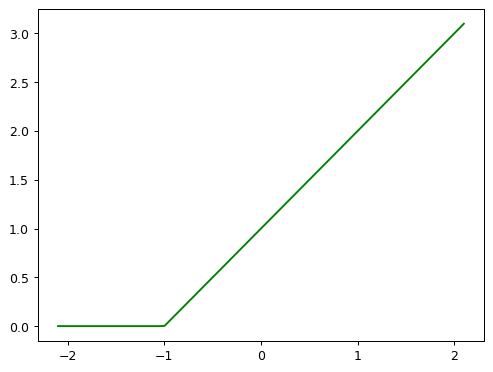

In [25]:
plot_function(partial(rectified_linear, 1, 1))

Alternatively we can use

In [27]:
import torch.nn.functional as F

In [28]:
def rectified_linear2(theta_params, b, x_input): 
    return F.relu(theta_params*x_input + b)


We can play with that operation

In [29]:
@interact(theta_params=1.5, b=1.5)
def plot_relu(theta_params, b):
    plot_function(partial(rectified_linear, theta_params, b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='theta_params', max=4.5, min=-1.5), FloatSlider(value…

`theta_params` changes the slope, and `b` changes where the "hook" appears.

What about the stack of two functions together?

In [30]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

The complexity and variety of the curves that we can model is larger.


...with enough of these rectified linear functions added together, you could approximate any function with a single input, to whatever accuracy you like! 